In [5]:
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet

face_detector = MTCNN()
MyFaceNet = FaceNet()

In [6]:
def create_signature(directory):
    signatures = list()
    
    for filename in listdir(directory):
        img_path = os.path.join(directory, filename)
        gbr1 = cv2.imread(img_path)
        
        wajah = face_detector.detect_faces(gbr1)
        
        if len(wajah)>0:
             for face1 in wajah:
                x1, y1, width, height = face1['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height


                # Extract facial landmarks
                facial_landmarks = face1['keypoints']
                left_eye = facial_landmarks['left_eye']
                right_eye = facial_landmarks['right_eye']
                nose = facial_landmarks['nose']
                mouth_left = facial_landmarks['mouth_left']
                mouth_right = facial_landmarks['mouth_right']

                # Draw facial landmarks on the image
                cv2.circle(gbr1, left_eye, 5, (0, 0, 255), -1)
                cv2.circle(gbr1, right_eye, 5, (0, 0, 255), -1)
                cv2.circle(gbr1, nose, 5, (0, 0, 255), -1)
                cv2.circle(gbr1, mouth_left, 5, (0, 0, 255), -1)
                cv2.circle(gbr1, mouth_right, 5, (0, 0, 255), -1)


                # crop and resize the face
                gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
                gbr = Image.fromarray(gbr)
                gbr_array = asarray(gbr)

                face = gbr_array[y1:y2, x1:x2]
                face = Image.fromarray(face)
                face = face.resize((160,160))
                face = asarray(face)

            
                face = expand_dims(face, axis=0)
                signature = MyFaceNet.embeddings(face)

                signatures.append(signature)
                
    return signatures

In [7]:
def load_dataset(directory):
    X,y = list(), list()
    
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        
        if not isdir(path):
            continue
            
        signatures = create_signature(path)
        labels = [subdir for _ in range(len(signatures))]
        
        X.extend(signatures)
        y.extend(labels)
        
    return asarray(X), asarray(y)

In [54]:
import os
from os import listdir
from os.path import isdir
import cv2
from PIL import Image
from numpy import asarray
from numpy import expand_dims

# load train dataset
testX, testy = load_dataset('RAF-D/Test/')
print(testX.shape, testy.shape)


1/1 [==============================] - 0s 106ms/step
(118, 1, 512) (118,)


In [55]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Pastikan ukuran sumbu pertama adalah 1 sebelum memampatkan
if testX.shape[1] != 1:
    testX = np.expand_dims(testX, axis=1)

# Kemudian lakukan pemampatan pada sumbu pertama
testX = np.squeeze(testX, axis=1)


encoder = LabelEncoder()
encoder.fit(testy)
encoded_Y = encoder.transform(testy)

test_y = to_categorical(encoded_Y)

In [56]:
from keras.models import load_model


labels=['jijik', 'marah', 'normal', 'sedih','senang','takut','terkejut']


modelSmile = load_model('MODEL_BARU14.h5')


In [57]:
#prediksi semua kelas
y_pred = modelSmile.predict(testX)

4/4 [==============================] - 2s 34ms/step


In [59]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

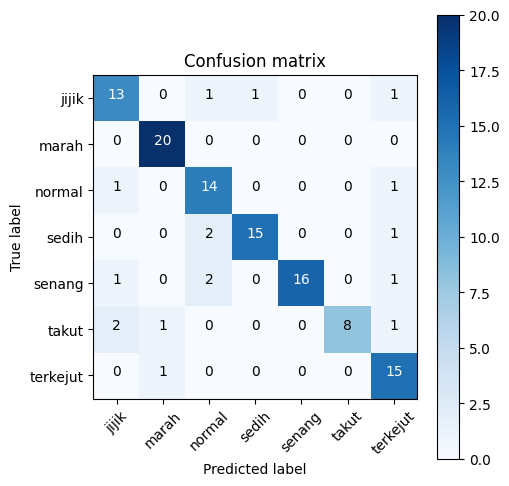

In [60]:
from sklearn.metrics import confusion_matrix
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix,classes=labels,normalize=False,
                      title='Confusion matrix')

In [61]:
from sklearn.metrics import classification_report


print('hasil')
print(classification_report(test_y.argmax(axis=1),y_pred.argmax(axis=1),target_names=labels))

hasil
              precision    recall  f1-score   support

       jijik       0.76      0.81      0.79        16
       marah       0.91      1.00      0.95        20
      normal       0.74      0.88      0.80        16
       sedih       0.94      0.83      0.88        18
      senang       1.00      0.80      0.89        20
       takut       1.00      0.67      0.80        12
    terkejut       0.75      0.94      0.83        16

    accuracy                           0.86       118
   macro avg       0.87      0.85      0.85       118
weighted avg       0.87      0.86      0.86       118

